In [3]:
import json
import numpy as np
import sys
import matplotlib.pyplot as plt

In [4]:
with open("groundtruth_hole18.json","r") as f:
    groundtruths = json.load(f)
#print(groundtruths)

In [5]:
with open("prediction_hole18.json","r") as f:
    detections = json.load(f)
#print(detections)

In [6]:
### 計算IOU ###
def get_iou(pred_box, gt_box):
    """
    pred_box : the coordinate for predict bounding box
    gt_box :   the coordinate for ground truth bounding box
    return :   the iou score
    the  left-down coordinate of  pred_box:(pred_box[0], pred_box[1])
    the  right-up coordinate of  pred_box:(pred_box[2], pred_box[3])
    """
    # 1.get the coordinate of inters
    ixmin = max(pred_box[0], gt_box[0])
    ixmax = min(pred_box[2], gt_box[2])
    iymin = max(pred_box[1], gt_box[1])
    iymax = min(pred_box[3], gt_box[3])

    iw = np.maximum(ixmax-ixmin+1., 0.)
    ih = np.maximum(iymax-iymin+1., 0.)

    # 2. calculate the area of inters
    inters = iw*ih

    # 3. calculate the area of union
    uni = ((pred_box[2]-pred_box[0]+1.) * (pred_box[3]-pred_box[1]+1.) +
           (gt_box[2] - gt_box[0] + 1.) * (gt_box[3] - gt_box[1] + 1.) -
           inters)

    # 4. calculate the overlaps between pred_box and gt_box
    iou = inters / uni
    return iou

In [7]:
### 計算AP (PASCAL VOC PAPER) ###
def voc_ap(rec, prec, use_07_metric=False):
    """ ap = voc_ap(rec, prec, [use_07_metric])
    Compute VOC AP given precision and recall.
    If use_07_metric is true, uses the
    VOC 07 11 point method (default:False).
    """
    if use_07_metric:
        # 11 point metric
        ap = 0.
        for t in np.arange(0., 1.1, 0.1):
            if np.sum(rec >= t) == 0:
                p = 0
            else:
                p = np.max(prec[rec >= t])
            ap = ap + p / 11.
    else:
        # correct AP calculation
        # first append sentinel values at the end
        mrec = np.concatenate(([0.], rec, [1.]))
        mpre = np.concatenate(([0.], prec, [0.]))

        # compute the precision envelope
        for i in range(mpre.size - 1, 0, -1):
            mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

        # to calculate area under PR curve, look for points
        # where X axis (recall) changes value
        i = np.where(mrec[1:] != mrec[:-1])[0]

        # and sum (\Delta recall) * prec
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return mrec, mpre, ap

In [10]:
def GetPascalVOCMetrics(detections, groundTruths, IOUThreshold=0.5):
    '''
    Get the metrics used by the VOC Pascal 2012 challenge.
    Get
    Args:
        detections # List with all detections 
        (Ex_Mask RCNN: [[ROI(bb coordinates X1Y1X2Y2)], class, confidence, imageName])
        groundTruths # List with all groundtruths
    Returns:
        A list of dictionaries. Each dictionary contains information and metrics of each class.'''
    APs = []
    ret = [] # list containing metrics (precision, recall, average precision) of each class
    classes = range(1,3) ################### 改class
    classes = sorted(classes)
    # Precision x Recall is obtained individually by each class
    # Loop through by classes
    for c in classes:
        # Get only detection of class c
        dects = []
        [dects.append(d) for d in detections if d[1] == c]
        # Get only ground truths of class c, use filename as key
        gts = {}
        npos = 0
        for g in groundTruths:
            if g[1] == c:
                npos += 1
                gts[g[2]] = gts.get(g[2], []) + [g]  ##imagename

        # sort detections by decreasing confidence
        dects = sorted(dects, key=lambda conf: conf[2], reverse=True)  #https://www.learncodewithmike.com/2019/12/python-lambda-functions.html
        #print(dects)
        TP = np.zeros(len(dects))
        FP = np.zeros(len(dects))
        # create dictionary with amount of gts for each image
        det = {key: np.zeros(len(gts[key])) for key in gts}

        # print("Evaluating class: %s (%d detections)" % (str(c), len(dects)))
        # Loop through detections
        for d in range(len(dects)):
            # print('dect %s => %s' % (dects[d][0], dects[d][3],))
            # Find ground truth image
            gt = gts[dects[d][3]] if dects[d][3] in gts else [] ###根據 imagename 找兩個有沒有匹配
            iouMax = sys.float_info.min
            for j in range(len(gt)):
                # print('Ground truth gt => %s' % (gt[j][3],))
                iou = get_iou(dects[d][0], gt[j][0])
                if iou > iouMax:
                    iouMax = iou
                    jmax = j
            # Assign detection as true positive/don't care/false positive
            if iouMax >= IOUThreshold:
                if det[dects[d][3]][jmax] == 0:
                    TP[d] = 1  # count as true positive
                    det[dects[d][3]][jmax] = 1  # flag as already 'seen'  ##根據bbox＿iou來判斷是否檢測過
                    # print("TP")
                else:
                    FP[d] = 1  # count as false positive
                    # print("FP")
            # - A detected "cat" is overlaped with a GT "cat" with IOU >= IOUThreshold.
            else:
                FP[d] = 1  # count as false positive
                # print("FP")
        # compute precision, recall and average precision
        acc_FP = np.cumsum(FP) # np.cumsum() 按位累加
        acc_TP = np.cumsum(TP)
        rec = acc_TP / npos
        prec = np.divide(acc_TP, (acc_FP + acc_TP))
        #compute ap
        mpre, mrec, ap = voc_ap(rec, prec, use_07_metric=False) 
        #compute mAP
        APs.append(ap)
        # add class result in the dictionary to be returned
        r = {
                'class': c,
                'precision': prec,
                'recall': rec,
                'AP': ap,
                'interpolated precision': mpre,
                'interpolated recall': mrec,
                'total positives': npos,
                'total TP': np.sum(TP),
                'total FP': np.sum(FP)
            }
        ret.append(r)
        
    print("mAP : ", np.mean(APs)*100, "%")
        
    return ret

In [11]:
GetPascalVOCMetrics(detections, groundtruths, IOUThreshold=0.5)

mAP :  76.92542506034317 %


[{'class': 1,
  'precision': array([1.        , 1.        , 1.        , 0.75      , 0.8       ,
         0.66666667, 0.71428571, 0.75      , 0.77777778, 0.8       ,
         0.81818182, 0.83333333, 0.84615385, 0.85714286, 0.86666667,
         0.875     , 0.82352941, 0.77777778, 0.78947368, 0.8       ,
         0.80952381, 0.81818182, 0.82608696, 0.83333333, 0.84      ,
         0.84615385, 0.85185185, 0.85714286, 0.86206897, 0.86666667,
         0.87096774, 0.875     , 0.87878788, 0.88235294, 0.88571429,
         0.88888889, 0.89189189, 0.89473684, 0.8974359 , 0.9       ,
         0.90243902, 0.9047619 , 0.90697674, 0.90909091, 0.88888889,
         0.89130435, 0.89361702, 0.89583333, 0.89795918, 0.88      ,
         0.8627451 , 0.86538462, 0.86792453, 0.87037037, 0.87272727,
         0.85714286, 0.84210526, 0.82758621, 0.81355932, 0.8       ,
         0.78688525, 0.77419355, 0.76190476, 0.75      , 0.73846154,
         0.74242424, 0.74626866, 0.73529412, 0.72463768, 0.71428571,
       

In [12]:
def PlotPrecisionRecallCurve(showAP=False,
                                 showInterpolatedPrecision=False,
                                 savePath=None,
                                 showGraphic=True):
        """PlotPrecisionRecallCurve
        Plot the Precision x Recall curve for a given class.
        Args:
            boundingBoxes: Object of the class BoundingBoxes representing ground truth and detected
            bounding boxes;
            IOUThreshold (optional): IOU threshold indicating which detections will be considered
            TP or FP (default value = 0.5);
            method (default = EveryPointInterpolation): It can be calculated as the implementation
            in the official PASCAL VOC toolkit (EveryPointInterpolation), or applying the 11-point
            interpolatio as described in the paper "The PASCAL Visual Object Classes(VOC) Challenge"
            or EveryPointInterpolation"  (ElevenPointInterpolation).
            showAP (optional): if True, the average precision value will be shown in the title of
            the graph (default = False);
            showInterpolatedPrecision (optional): if True, it will show in the plot the interpolated
             precision (default = False);
            savePath (optional): if informed, the plot will be saved as an image in this path
            (ex: /home/mywork/ap.png) (default = None);
            showGraphic (optional): if True, the plot will be shown (default = True)
        Returns:
            A list of dictionaries. Each dictionary contains information and metrics of each class.
        """
        results = GetPascalVOCMetrics(detections, groundtruths, IOUThreshold=0.5)
        result = None
        # Each result represents a class
        for result in results:
            if result is None:
                raise IOError('Error: Class %d could not be found.' % classId)

            classId = result['class']
            precision = result['precision']
            recall = result['recall']
            average_precision = result['AP']
            mpre = result['interpolated precision']
            mrec = result['interpolated recall']
            npos = result['total positives']
            total_tp = result['total TP']
            total_fp = result['total FP']

            plt.close()
            '''
            if showInterpolatedPrecision:
                if method == MethodAveragePrecision.EveryPointInterpolation:
                    plt.plot(mrec, mpre, '--r', label='Interpolated precision (every point)')
                elif method == MethodAveragePrecision.ElevenPointInterpolation:
                    # Uncomment the line below if you want to plot the area
                    # plt.plot(mrec, mpre, 'or', label='11-point interpolated precision')
                    # Remove duplicates, getting only the highest precision of each recall value
                    nrec = []
                    nprec = []
                    for idx in range(len(mrec)):
                        r = mrec[idx]
                        if r not in nrec:
                            idxEq = np.argwhere(mrec == r)
                            nrec.append(r)
                            nprec.append(max([mpre[int(id)] for id in idxEq]))
                    plt.plot(nrec, nprec, 'or', label='11-point interpolated precision')'''
            plt.plot(recall, precision, label='Precision')
            plt.xlabel('recall')
            plt.ylabel('precision')
            if showAP:
                ap_str = "{0:.2f}%".format(average_precision * 100)
                # ap_str = "{0:.4f}%".format(average_precision * 100)
                plt.title('Precision x Recall curve \nClass: %s, AP: %s' % (str(classId), ap_str))
            else:
                plt.title('Precision x Recall curve \nClass: %s' % str(classId))
            plt.legend(shadow=True)
            plt.grid()
            
            if savePath is not None:
                plt.savefig(os.path.join(savePath, classId + '.png'))
            if showGraphic is True:
                plt.show()
                # plt.waitforbuttonpress()
                plt.pause(0.05)
        return results

mAP :  76.92542506034317 %


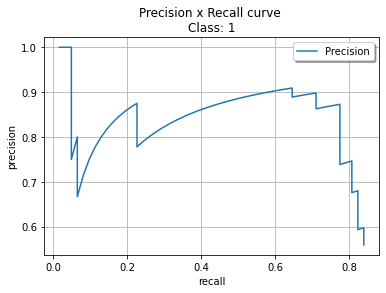

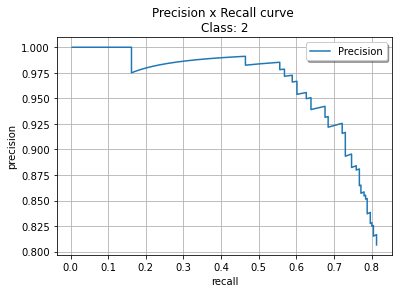

[{'class': 1,
  'precision': array([1.        , 1.        , 1.        , 0.75      , 0.8       ,
         0.66666667, 0.71428571, 0.75      , 0.77777778, 0.8       ,
         0.81818182, 0.83333333, 0.84615385, 0.85714286, 0.86666667,
         0.875     , 0.82352941, 0.77777778, 0.78947368, 0.8       ,
         0.80952381, 0.81818182, 0.82608696, 0.83333333, 0.84      ,
         0.84615385, 0.85185185, 0.85714286, 0.86206897, 0.86666667,
         0.87096774, 0.875     , 0.87878788, 0.88235294, 0.88571429,
         0.88888889, 0.89189189, 0.89473684, 0.8974359 , 0.9       ,
         0.90243902, 0.9047619 , 0.90697674, 0.90909091, 0.88888889,
         0.89130435, 0.89361702, 0.89583333, 0.89795918, 0.88      ,
         0.8627451 , 0.86538462, 0.86792453, 0.87037037, 0.87272727,
         0.85714286, 0.84210526, 0.82758621, 0.81355932, 0.8       ,
         0.78688525, 0.77419355, 0.76190476, 0.75      , 0.73846154,
         0.74242424, 0.74626866, 0.73529412, 0.72463768, 0.71428571,
       

In [13]:
PlotPrecisionRecallCurve()